# Pregunta 3

#### Se tiene una partícula de masa $m = 1$ en un campo gravitacional $\vec{g} = −9.8 \hat{j}$ en una caja con piso en forma de v a un ángulo $\alpha$, de lado $L=10$ m y $d=3$ m. Realice los ejercicios con valores de $\alpha=\pi/6 \ $ y $ \ \alpha = \pi/10$.


#### a)Realice una simulación con condición inicial tal que la posición inicial es sobre la rampa a un tercio de la distancia de la pared vertical izquierda y el vértice inferior de la caja, y se dispara con velocidad $\vert \vec{v} \vert = 1$ hacia la derecha con ángulos $\alpha$ sobre la horizontal $\alpha$, $2\alpha$ y $3\alpha$. (Para que la simulación sea válida, la partícula debe rebotar al menos 20 veces con alguna parte de la caja).

In [46]:
from pylab import*
from numpy import*
%matplotlib inline

In [47]:
def rk4(ec,p_ini,x,args=0,h=0.1):
    #el parámetro args está evaluándose en la segunda coordenada de la ecuación diferencial
    #éste escalar será la fricción que estamos añadiendo a la función.
    
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10.
    #codigo adicional para hacer que cuando se acerque al punto 
    #de rebote los pasos sean más pequeños y nunca sobrepase la barrera.
    
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    
    if args==0:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    else:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    return tiempos,sol

La ecuación para que una pelota rebote es:

$$
m\ddot{\vec{a}} = -g \hat{j}
$$

Separándola en coordenadas sería:

$$
\ddot{x_1} =0
$$

$$
\ddot{x_2} + \frac{g}{m} = 0
$$

Entonces, las ecuaciones de movimiento quedarían como:

In [48]:
#x[0]=posición_x, x[1]=posición_y, x[2]=vel_x, x[3]=vel_y

def ec_mov(x,t,g=9.8,m=1):
    dx= x[2]
    dy= x[3]
    ddy= -g/m
    ddx= 0
    return array([dx,dy,ddx,ddy])

Para imponer las condiciones de rebote con piso, vamos a pedir que la velocidad se refleje con respecto a la normal del suelo cuando la pelota toque el suelo de la caja, es decir:

$$
\text{Si } \ \ \ (x_2-\vert \ x_1 \vert \tan(\alpha)) < 0 \ \ \ \ \ \Rightarrow \ \ \ \ \ \vec{v}= \begin{cases}
        ( v_x\cos(\alpha) - v_y\sin(\alpha), v_x\sin(\alpha) + v_y\cos(\alpha)) \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{ si } \ \ v_x > 0
        \\
        ( v_x\cos(-\alpha) - v_y\sin(-\alpha), v_x\sin(-\alpha) + v_y\cos(-\alpha)) \ \ \ \ \ \ \text{ si } \ \ v_x \leq 0
        \end{cases}
$$

In [49]:
def rebote_piso(ec,pto,ang,mi_dt,h,N):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec,pto,[0,dt_busqueda],h,N)
    y_izq = pto
    y_med = sol[-1,:]
    while abs(y_izq[1]- tan(ang)*abs(y_izq[0])) > 1e-5:
        if (y_izq[1]- tan(ang)*abs(y_izq[0]))*(y_med[1]- tan(ang)*abs(y_med[0])) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec,reinicio,[0,dt_busqueda],h,N)
        y_izq = reinicio   
        y_med = sol[-1,:]
    if (y_izq[0]) <= 0:
        y_izq=array([y_izq[0],y_izq[1],y_izq[2]*cos(ang)-y_izq[3]*sin(ang),y_izq[2]*sin(ang)+y_izq[3]*cos(ang)])
    else:
        y_izq=array([y_izq[0],y_izq[1],y_izq[2]*cos(-ang)-y_izq[3]*sin(-ang),y_izq[2]*sin(-ang)+y_izq[3]*cos(-ang)])
    return y_izq

Para imponer las condiciones de rebote con paredes, vamos a pedir que la velocidad en x cambie de dirección cuando la pelota toque la pared de la caja, es decir:

$$
\text{Si } \ \ \ (5-\vert \ x_1 \vert ) < 0 \ \ \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \ \ \vec{v}= (-v_x,v_y)
$$

In [50]:
def rebote_pared(ec,pto,mi_dt,h,N):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec,pto,[0,dt_busqueda],h,N)
    y_izq = pto
    y_med = sol[-1,:]
    while 5 - abs(y_izq[0]) < 1e-5:
        if (5 - abs(y_izq[0]))*(5 - abs(y_med[0])) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec,reinicio,[0,dt_busqueda],h,N)
        y_izq = reinicio   
        y_med = sol[-1,:]
    y_izq=array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    return y_izq

Para imponer las condiciones de rebote con paredes, vamos a pedir que la velocidad en y cambie de dirección cuando la pelota toque el techo de la caja, es decir:

$$
\text{Si } \ \ \ (5\tan(\alpha)+3- y_1) < 0 \ \ \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \ \ \vec{v}= (v_x,-v_y)
$$

In [51]:
def rebote_techo(ec,pto,ang,mi_dt,h,N):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec,pto,[0,dt_busqueda],h,N)
    y_izq = pto
    y_med = sol[-1,:]
    while ((5*tan(ang)+3)-y_izq[1]) < 1e-5:
        if ((5*tan(ang)+3)-y_izq[1])*((5*tan(ang)+3)-y_med[1]) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec,reinicio,[0,dt_busqueda],h,N)
        y_izq = reinicio   
        y_med = sol[-1,:]
    y_izq=array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

A continuación vamos a describir la trayectoria con las condiciones que impusimos:

In [52]:
def trayec(ec,pto_ini,ang,h=0.1,N=100,mi_dt=0.1):
    trayectoria = zeros((N,len(pto_ini)))
    trayectoria[0,:]=array(pto_ini)
    for i in range(N-1):
        t,sol_dt=rk4(ec,trayectoria[i,:],[0,mi_dt],h,N)
        if sol_dt[-1,:][1] - tan(ang)*abs(sol_dt[-1,:][0]) < 0 :
            punto_y = rebote_piso(ec,trayectoria[i,:],ang,mi_dt,h,N)
            trayectoria[i+1,:] = punto_y
        elif (5 - abs(sol_dt[-1,:][0])) <0 :
            punto_x = rebote_pared(ec,trayectoria[i,:],mi_dt,h,N)
            trayectoria[i+1,:] = punto_x
        elif (5*tan(ang)+3 - sol_dt[-1,:][1]) < 0:
            punto_z = rebote_techo(ec,trayectoria[i,:],ang,mi_dt,h,N)
            trayectoria[i+1,:] = punto_z
        else:
            trayectoria[i+1,:]=sol_dt[-1,:]
    return trayectoria


Las condiciones del problema son:

In [53]:
#ángulos de la caja con el piso
alp=[pi/6,pi/10]

In [54]:
#angulo=angulo de la velocidad, alpha=angulo del piso, r=modulo de la velocidad
def p_ini(alpha,angulo,r):
    x=-5+(5./3)
    y=tan(alpha)*(5-(5./3))
    v_x=r*cos(angulo)
    v_y=r*sin(angulo)
    return [x,y,v_x,v_y]

#### Rebote sin fricción

Como no se especifica en que ángulo está la velocidad, vamos a usar un águlo de $\pi/3$ y un módulo de 1. 

(Otros ángulos y módulos también funcionan :) )

In [70]:
def grafica(ec,alpha,angulo,r,h=0.1,N=100):
    fig = figure(figsize=(14,14))
    
    ax = fig.add_subplot(221)
    bx = fig.add_subplot(222)

    trayectoria1=trayec(ec,p_ini(alpha[0],angulo,r),alpha[0],h,N)
    ax.plot(trayectoria1[:,0],trayectoria1[:,1],'o-')
    caja_x1 = [0,5,5,-5,-5,0]
    caja_y1 = [0,5*tan(alpha[0]),5*tan(alpha[0])+3,5*tan(alpha[0])+3,5*tan(alpha[0]),0]
    ax.plot(caja_x1,caja_y1)
    
    trayectoria2=trayec(ec,p_ini(alpha[1],angulo,r),alpha[1],h,N)
    bx.plot(trayectoria2[:,0],trayectoria2[:,1],'o-')
    caja_x2 = [0,5,5,-5,-5,0]
    caja_y2 = [0,5*tan(alpha[1]),5*tan(alpha[1])+3,5*tan(alpha[1])+3,5*tan(alpha[1]),0]
    bx.plot(caja_x2,caja_y2)
    
    ax.set_title('Piso con angulo de 30 grados.')
    bx.set_title('Piso con angulo de 18 grados.')
    
    show()

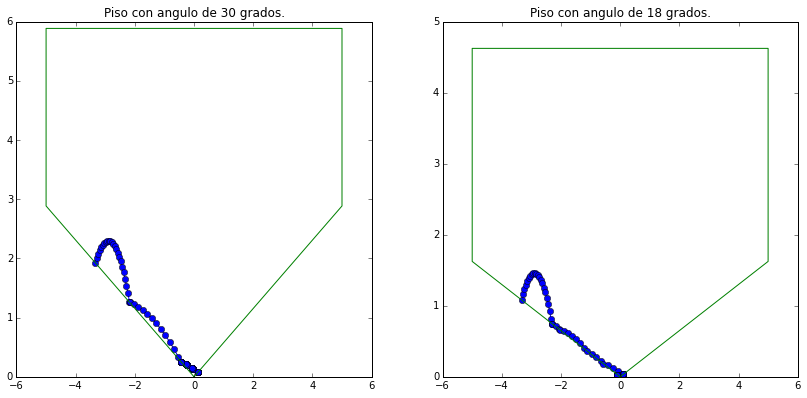

In [151]:
grafica(ec_mov,[alpha1,alpha2],pi/3,1,h=1,N=500)

#### b) Introduzca algún modelo de fricción y compare las trayectorias con el inciso anterior.

En éste caso, las ecuaciones diferenciales que describen el movimiento de la una pelota son:

$$
m\ddot{\vec{a}} = -g \hat{j} -f\dot{\hat{x}}
$$

Como modelo de fricción proponemos:

$$ 
f = \mu \ \vert \ \vec{v} \ \vert^3 
$$

La anterior ecuación se puede separar en coordenadas, quedando como:

$$
\ddot{x_1} + \frac{\mu}{m} \vert \vec{v} \vert ^3 = 0
$$

$$
\ddot{x_2} + \frac{g}{m} + \frac{\mu}{m} \vert \vec{v} \vert ^3 = 0
$$

Por lo tanto las ecuaciones de mov se pueden escribir como:

In [88]:
#x[0]=posición_x, x[1]=posición_y, x[2]=vel_x, x[3]=vel_y

def ec_mov_f(x,t,mu=0.1,g=9.8,m=1):
    vel = (x[2]**2 + x[3]**2)**(1.5)
    dx = x[2]
    dy = x[3]
    ddx= - (mu/m)*vel*x[2]
    ddy= - g/m - (mu/m)*vel*x[3]
    return array([dx,dy,ddx,ddy])

Las condiciones de rebote con la pared y piso son exactamente las mismas, solo que ahora al resolver la ecuación diferencial vamos a usar la ecuación que llamamos $\text{ec_mov_f}$:

#### Rebote con fricción

Usando el mismo ángulo y módulo para la velocidad, obtenemos que cuando hay fricción proporcional al cubo del módulo de la velocidad, la trayectoria se modifica de la siguiente forma:

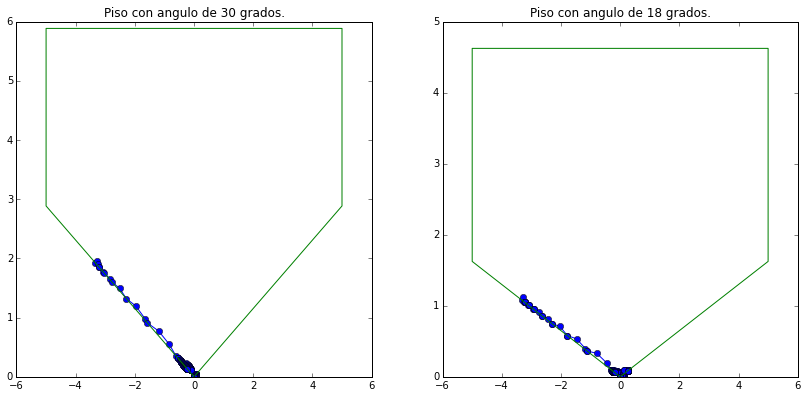

In [101]:
grafica(ec_mov_f,[alpha1,alpha2],pi/3,1,h=0.01,N=500)

Comparadas con las gráficas del inciso a, podemos notar que la amplitud del rebote se reduce considerablemente con las mismas condiciones iniciales. Y aunque es un plano inclinado y la pelota se acelera al caer más distancia en cada rebote, la fricción que se impuso al modelo no hace evidente esta aceleración, de hecho, cuando el plano inclinado es de 30º la pelota nisiquiera llega al vértice de la caja: deja de rebotar antes a causa de la fricción.

#### c) Realice los ejercicios en los incisos (3a) y (3b) pero ahora $\vert v \vert = 25$ y $\vert v \vert = 60$. Describa las similitudes y diferencias entre las distintas simulaciones.

En éstos casos vamos a necesitar pasos más pequeños en el integrador, entonces:

#### Para una velocidad con magnitud 25 sin fricción

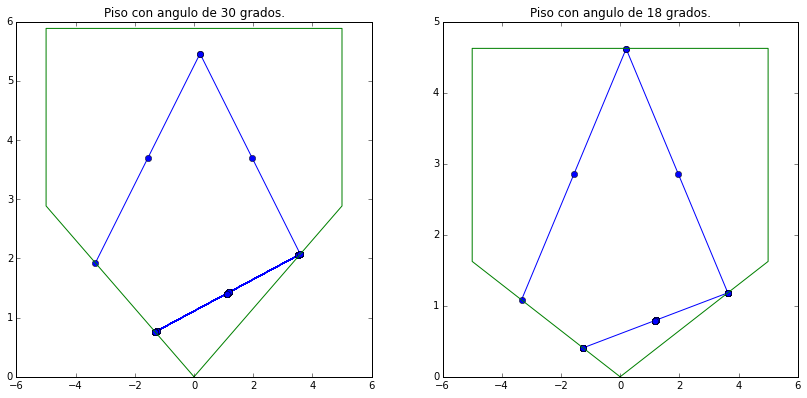

In [121]:
grafica(ec_mov,[alpha1,alpha2],pi/4,25,h=1e-10,N=500)

#### Para una velocidad con magnitud 25 con fricción

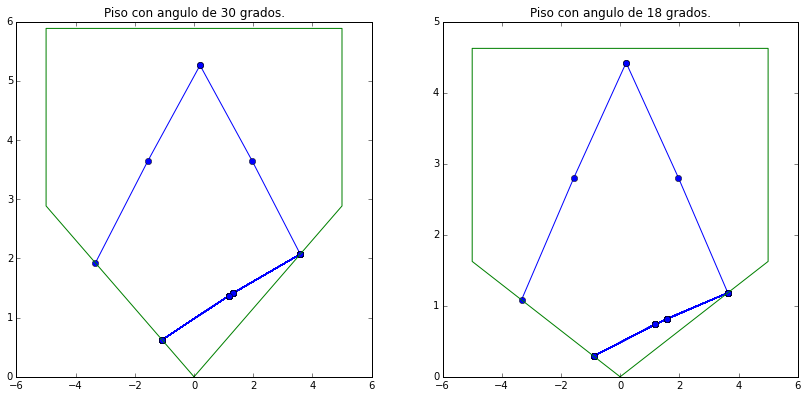

In [120]:
grafica(ec_mov_f,[alpha1,alpha2],pi/4,25,h=1e-20,N=500)

#### Para una velocidad con magnitud 60 sin fricción

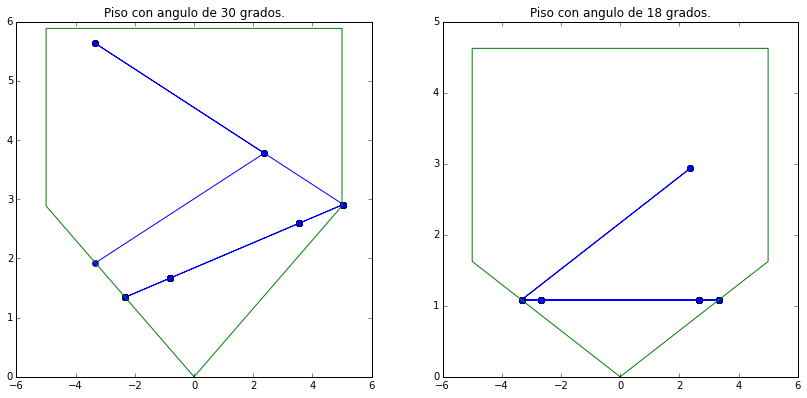

In [129]:
grafica(ec_mov,[alpha1,alpha2],pi/10,60,h=1e-20,N=500)

#### Para una velocidad con magnitud 60 con fricción

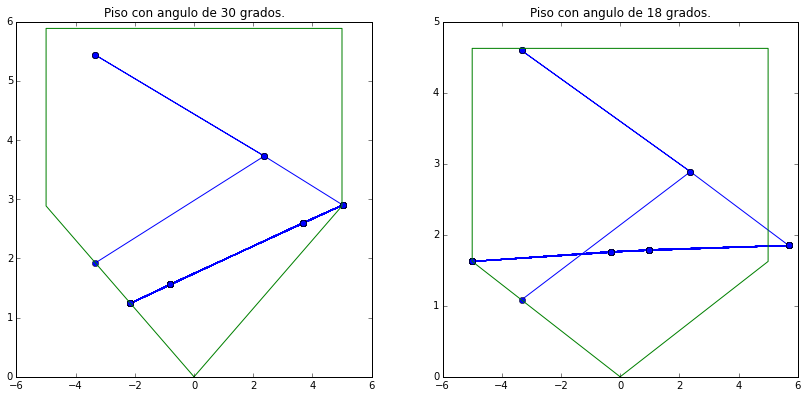

In [130]:
grafica(ec_mov_f,[alpha1,alpha2],pi/10,60,h=1e-20,N=500)

#### d) Dibuje el espacio fase $p_x$ , $x$ y $p_y$ , $y$ cuando no hay fricción y la partícula es lanzada hacia la derecha a un ángulo $\alpha$ y vertical hacia arriba. Tome en cuenta el número necesario de rebotes para que la simulación pueda barrer el espacio fase de manera representativa.

Notemos que como m=1, basta graficar $v_i$ contra $x_i$ en cada caso, entonces:

#### Sin fricción, para caja con piso en ángulo de $\pi/6$

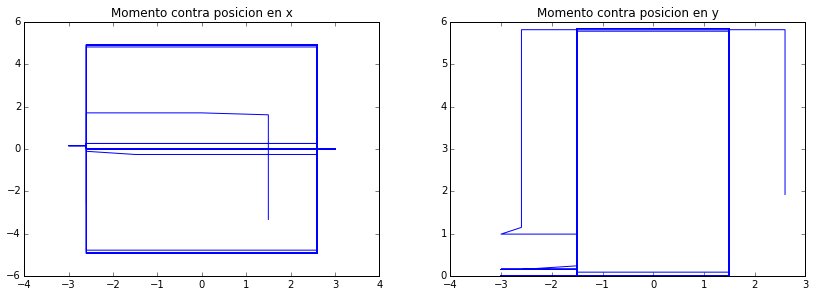

In [137]:
tra=trayec(ec_mov,p_ini(alpha[0],pi/3,3),alpha[0],h=0.000001,N=1000)

fig = figure(figsize=(14,10))

a1 = fig.add_subplot(221)
plot(tra[:,2],tra[:,0])
title('Momento contra posicion en x')
a2 = fig.add_subplot(222)
plot(tra[:,3],tra[:,1])
title('Momento contra posicion en y')
show()

#### Sin fricción, para caja con piso en ángulo de $\pi/10$

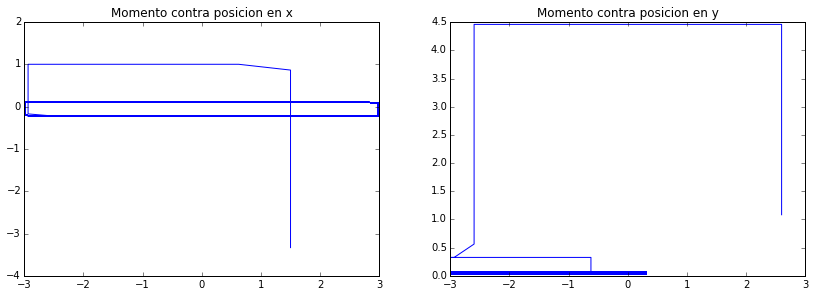

In [140]:
tra2=trayec(ec_mov,p_ini(alpha[1],pi/3,3),alpha[1],h=0.0001,N=1000)

fig = figure(figsize=(14,10))

a1 = fig.add_subplot(221)
plot(tra2[:,2],tra2[:,0])
title('Momento contra posicion en x')
a2 = fig.add_subplot(222)
plot(tra2[:,3],tra2[:,1])
title('Momento contra posicion en y')
show()

#### Con fricción, para caja con piso en ángulo de $\pi/6$

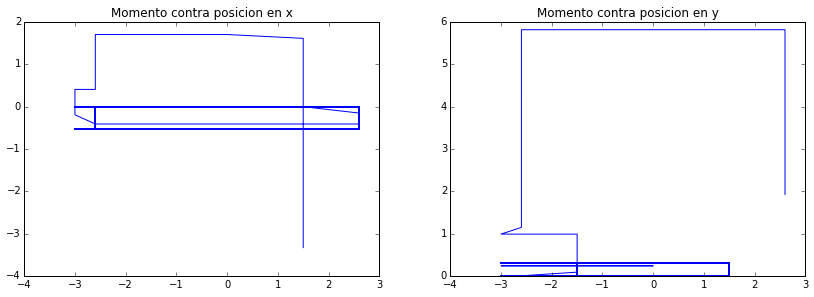

In [142]:
tra4=trayec(ec_mov,p_ini(alpha[0],pi/3,3),alpha[0],h=0.0001,N=1000)

fig = figure(figsize=(14,10))

a1 = fig.add_subplot(221)
plot(tra4[:,2],tra4[:,0])
title('Momento contra posicion en x')
a2 = fig.add_subplot(222)
plot(tra4[:,3],tra4[:,1])
title('Momento contra posicion en y')
show()

#### Con fricción, para caja con piso en ángulo de $\pi/10$

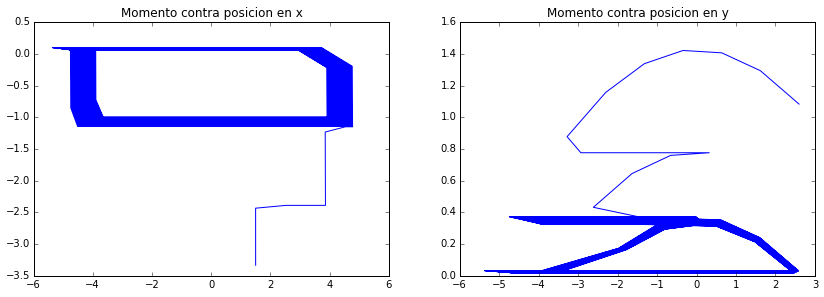

In [141]:
tra3=trayec(ec_mov_f,p_ini(alpha[1],pi/3,3),alpha[1],h=0.0001,N=1000)

fig = figure(figsize=(14,10))

a1 = fig.add_subplot(221)
plot(tra3[:,2],tra3[:,0])
title('Momento contra posicion en x')
a2 = fig.add_subplot(222)
plot(tra3[:,3],tra3[:,1])
title('Momento contra posicion en y')
show()